# Fitting a Model with InSession

In [18]:
import os
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from pathlib import Path

script_dir = Path.cwd()
data_dir = script_dir.parent / "data"
file_path = data_dir / "cleaned_data2.csv"
df = pd.read_csv(file_path)

df["DateReported"] = pd.to_datetime(df["DateReported"], errors="coerce", utc=True)

# Aggregate data
df_weekly = df.set_index("DateReported").resample("W").agg({
    "InSession": "max"  # 1 if UVA was in session at least once that week, else 0
}).reset_index()

# Add the CrimeCount column by counting rows per week
df_weekly["CrimeCount"] = df.resample("W", on="DateReported").size().values


# Rename columns for Prophet
df_weekly = df_weekly.rename(columns={"DateReported": "ds", "CrimeCount": "y"})

# Sort by date
df_weekly = df_weekly.sort_values("ds")

# Ensure 'ds' is in datetime format and remove timezone
df_weekly["ds"] = pd.to_datetime(df_weekly["ds"]).dt.tz_localize(None)

# Initialize model
model1 = Prophet(
    yearly_seasonality=True,  # Enable annual seasonality
    weekly_seasonality=True,  # Enable weekly seasonality
    daily_seasonality=False,  # Disable daily since it's too granular
)

# Add UVA regressor
model1.add_regressor("InSession")

# Fit model
model1.fit(df_weekly)

future1 = model1.make_future_dataframe(periods=52, freq="W")  # Predict 1 year ahead

# Add UVA session indicator to future data
future1["InSession"] = future1["ds"].apply(lambda x: 1 if x.month in [1, 2, 3, 8, 9, 10, 11] else 0)

# Predict
forecast1 = model1.predict(future1)

# Display forecast
forecast1[["ds", "yhat", "yhat_lower", "yhat_upper"]].head()


/var/folders/r9/vr40l1ss0v71ty4xxtt_10j00000gn/T/ipykernel_49407/896754694.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["DateReported"] = pd.to_datetime(df["DateReported"], errors="coerce", utc=True)
10:41:48 - cmdstanpy - INFO - Chain [1] start processing
10:41:48 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
0,2019-10-06,78.322721,59.076791,99.042557
1,2019-10-13,81.588148,62.049616,101.224708
2,2019-10-20,89.967986,70.683273,111.094380
3,2019-10-27,95.457429,74.289960,116.030480
4,2019-11-03,92.107875,72.239325,111.780183


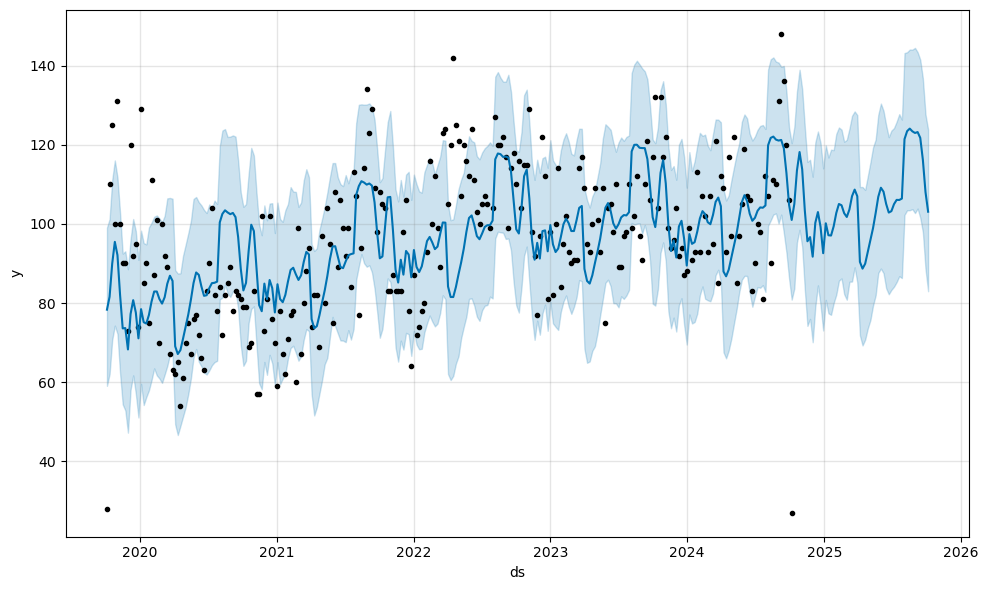

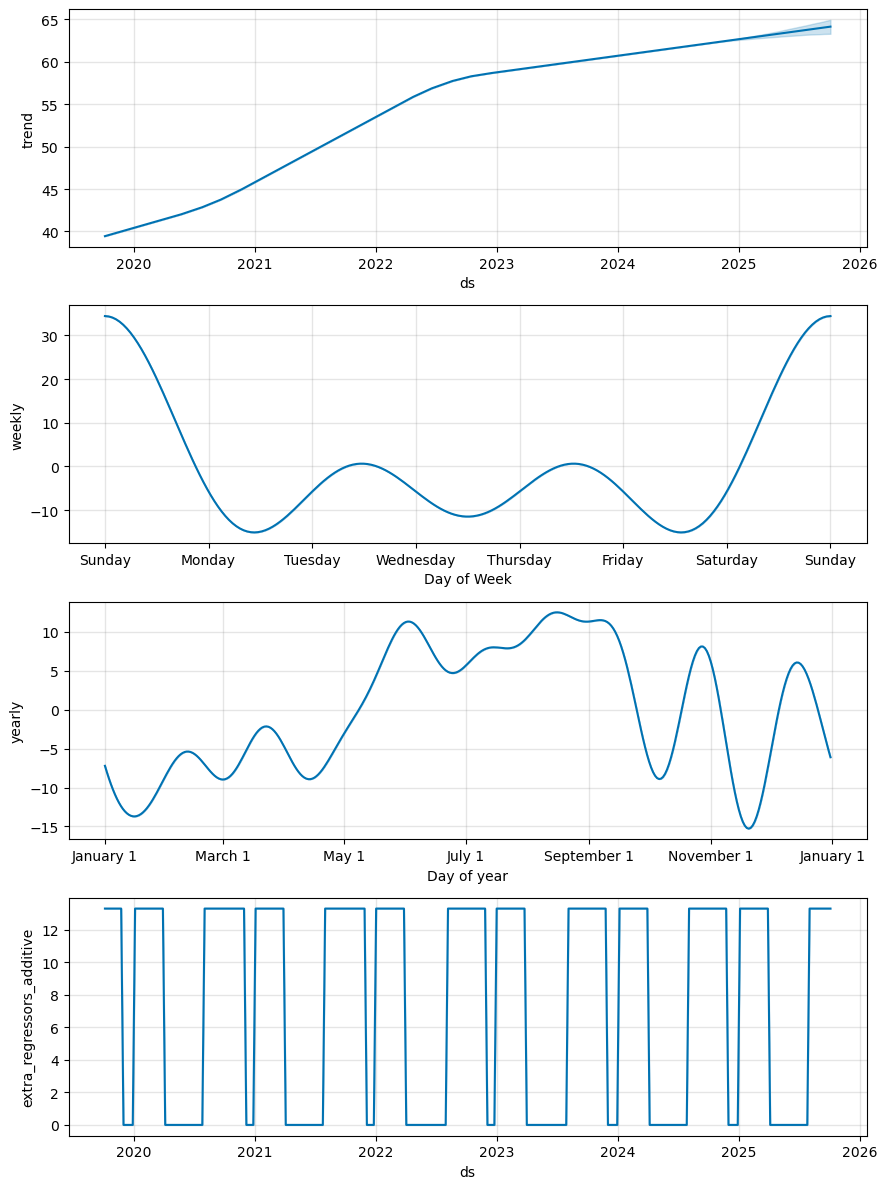

In [19]:
import matplotlib.pyplot as plt

# Plot forecast
fig = model1.plot(forecast1)
plt.show()

# Plot seasonality components
fig2 = model1.plot_components(forecast1)
plt.show()


In [20]:
# Evaluate model

from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error

# Use past data for testing
train_size = int(len(df_weekly) * 0.8)
train, test = df_weekly.iloc[:train_size], df_weekly.iloc[train_size:]

model_val1 = Prophet(
    yearly_seasonality=True,  # Enable annual seasonality
    weekly_seasonality=True,  # Enable weekly seasonality
    daily_seasonality=False,  # Disable daily since it's too granular
)

# Fit on training set
model_val1.fit(train)

# Predict on test set
test_forecast1 = model_val1.predict(test)

# Evaluate
mae1 = mean_absolute_error(test["y"], test_forecast1["yhat"])
rmse1 = root_mean_squared_error(test["y"], test_forecast1["yhat"])
mape1 = mean_absolute_percentage_error(test["y"], test_forecast1["yhat"])

print(f"MAE: {mae1}")
print(f"RMSE: {rmse1}")
print(f"MAPE: {mape1}")


10:41:50 - cmdstanpy - INFO - Chain [1] start processing
10:41:50 - cmdstanpy - INFO - Chain [1] done processing


MAE: 12.221739029161725
RMSE: 17.571802007269326
MAPE: 0.16480361748447173


# Fitting a Model with Holidays (no InSession)

In [21]:
import os
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from pathlib import Path

script_dir = Path.cwd()
data_dir = script_dir.parent / "data"
file_path = data_dir / "cleaned_data2.csv"
df = pd.read_csv(file_path)

df["DateReported"] = pd.to_datetime(df["DateReported"], errors="coerce", utc=True)
df_weekly = df.resample("W", on="DateReported").size().reset_index()
df_weekly = df_weekly.rename(columns={"DateReported": "ds", 0: "y"})
df_weekly["ds"] = df_weekly["ds"].dt.tz_localize(None)
df_weekly = df_weekly.sort_values("ds")

# Define UVA holidays
uva_holidays = []
start_year, end_year = 2019, 2023

for year in range(start_year, end_year + 1):
    uva_holidays.extend([
        {"holiday": "Fall semester start", "ds": f"{year}-08-24"},
        {"holiday": "Fall semester end", "ds": f"{year}-12-06"},
        {"holiday": "Winter break start", "ds": f"{year}-12-07"},
        {"holiday": "Winter break end", "ds": f"{year}-01-17"},
        {"holiday": "Spring semester start", "ds": f"{year}-01-18"},
        {"holiday": "Spring semester end", "ds": f"{year}-05-02"},
        {"holiday": "Summer break start", "ds": f"{year}-05-03"},
        {"holiday": "Summer break end", "ds": f"{year}-08-23"},
    ])

# Convert holidays to DataFrame with window effects
uva_holidays = pd.DataFrame(uva_holidays)
uva_holidays["ds"] = pd.to_datetime(uva_holidays["ds"])
uva_holidays["lower_window"] = uva_holidays["holiday"].apply(lambda x: -5 if "break" in x else -2)
uva_holidays["upper_window"] = uva_holidays["holiday"].apply(lambda x: 5 if "break" in x else 2)

# Initialize Prophet model with holidays
model2 = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    holidays=uva_holidays  # Incorporate UVA holidays
)

# Fit model
df_weekly["ds"] = pd.to_datetime(df_weekly["ds"]).dt.tz_localize(None)
model2.fit(df_weekly)

# Make future predictions
future2 = model2.make_future_dataframe(periods=104, freq="W")
forecast2 = model2.predict(future2)

# Display forecast
forecast2[["ds", "yhat", "yhat_lower", "yhat_upper"]].head()


/var/folders/r9/vr40l1ss0v71ty4xxtt_10j00000gn/T/ipykernel_49407/1479560804.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["DateReported"] = pd.to_datetime(df["DateReported"], errors="coerce", utc=True)
10:41:51 - cmdstanpy - INFO - Chain [1] start processing
10:41:51 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
0,2019-10-06,75.842112,56.146362,95.373567
1,2019-10-13,80.626253,60.891111,98.627917
2,2019-10-20,89.593809,69.280469,108.335946
3,2019-10-27,94.106372,75.304093,113.815064
4,2019-11-03,89.663119,70.378568,109.332400


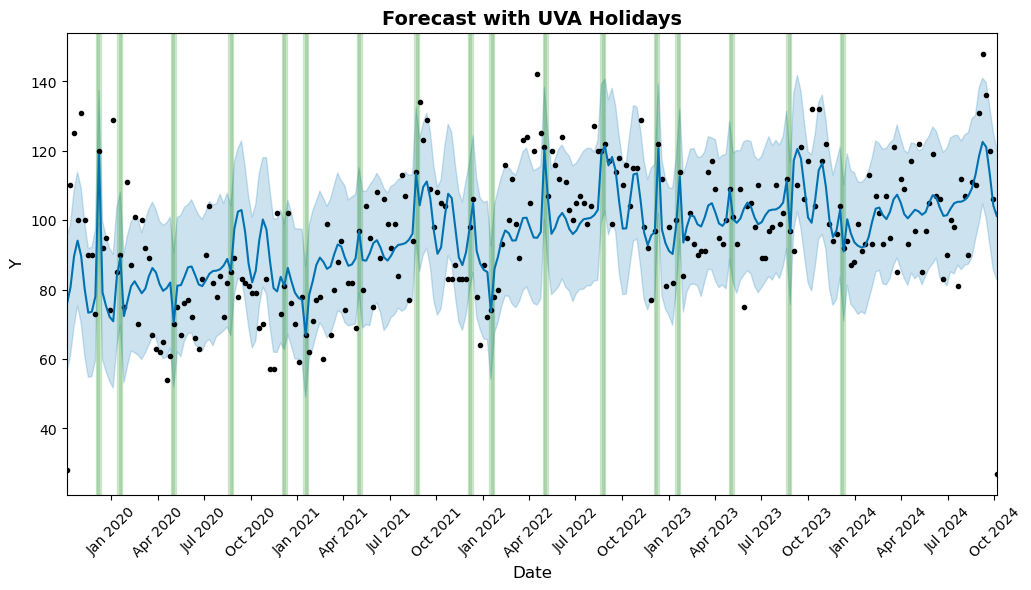

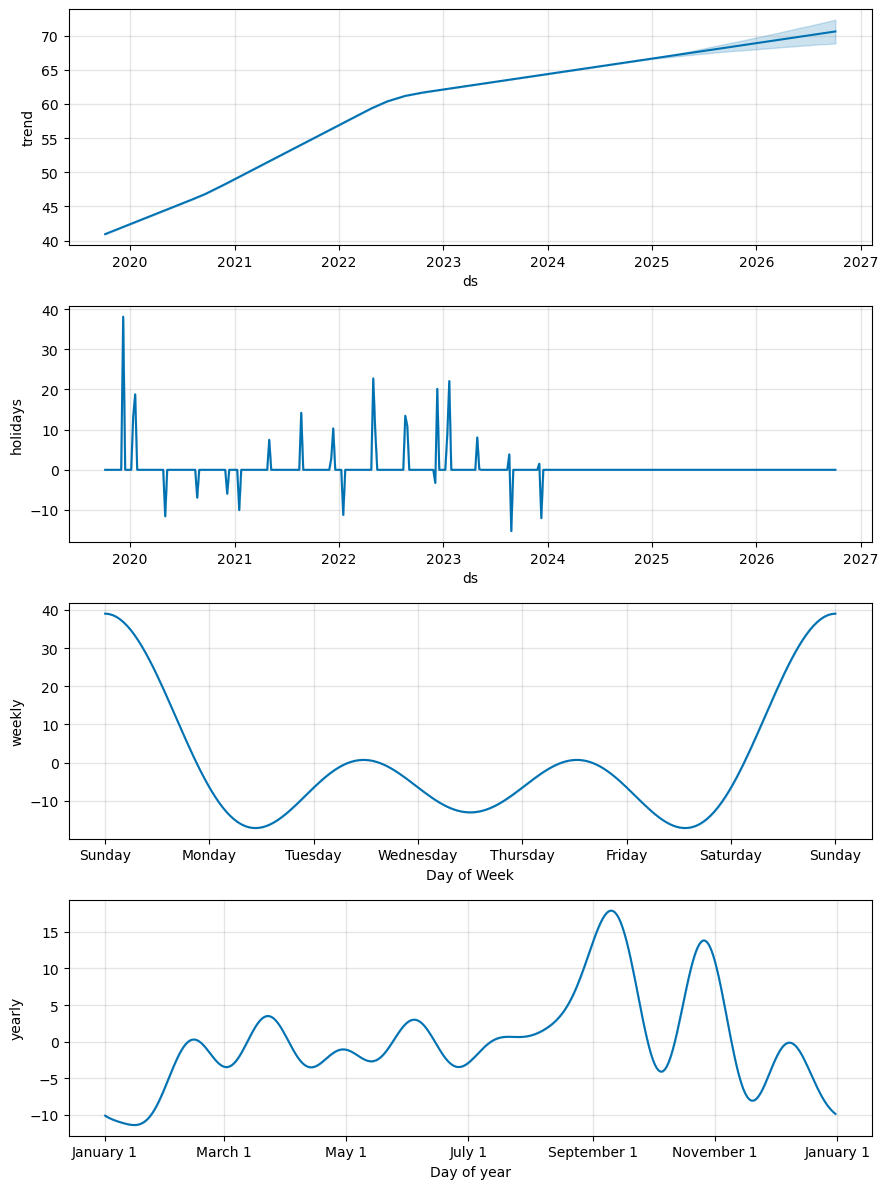

In [22]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Define the cutoff date for plotting
cutoff_date = pd.Timestamp("2019-10-06")

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))


model2.plot(forecast2, ax=ax)
ax.get_lines()[0].set_linewidth(2)

ax.set_xlim([cutoff_date, df_weekly["ds"].max()])

# Shade holidays
for _, row in uva_holidays.iterrows():
    holiday_start = row["ds"] + pd.Timedelta(days=row["lower_window"])
    holiday_end = row["ds"] + pd.Timedelta(days=row["upper_window"])

    if holiday_end >= cutoff_date:
        ax.axvspan(holiday_start, holiday_end, color="green", alpha=0.15)  # Softer shading

ax.get_children()[-1].set_alpha(0.6)  # Reduce opacity of scatter points

# Format x-axis labels for every 6 months
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Every 3 months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format as "Jan 2021", "Jul 2021"

plt.xticks(rotation=45)

ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Y", fontsize=12)
ax.set_title("Forecast with UVA Holidays", fontsize=14, fontweight="bold")

# Show the plot
ax.grid(False) # Hide grid lines
plt.show()

# Plot seasonality components
fig2 = model2.plot_components(forecast2)
plt.show()


In [23]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error

# Validation
# Split dataset for validation
train_size = int(len(df_weekly) * 0.8)
train, test = df_weekly.iloc[:train_size], df_weekly.iloc[train_size:]

# Initialize new Prophet model for validation
model_val2 = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    holidays=uva_holidays  # Include holidays in validation model
)

# Fit model on training set
model_val2.fit(train)

# Predict on test set
test_forecast2 = model_val2.predict(test)

# Evaluate model
mae2 = mean_absolute_error(test["y"], test_forecast2["yhat"])
rmse2 = root_mean_squared_error(test["y"], test_forecast2["yhat"])
mape2 = mean_absolute_percentage_error(test["y"], test_forecast2["yhat"])

print(f"\nMAE: {mae2}")
print(f"RMSE: {rmse2}")
print(f"MAPE: {mape2}")


10:41:52 - cmdstanpy - INFO - Chain [1] start processing
10:41:52 - cmdstanpy - INFO - Chain [1] done processing



MAE: 11.820485635491181
RMSE: 17.310910064515372
MAPE: 0.16044533874170602


# Fitting a Model with InSession *and* Holidays

In [24]:
x = "/content/ds4002_project2/data/cleaned_data2.csv"

In [25]:
import os
import pandas as pd
from prophet import Prophet
from pathlib import Path

# File paths
script_dir = Path.cwd()
data_dir = script_dir.parent / "data"
file_path = data_dir / "cleaned_data2.csv"




# Read the data
df = pd.read_csv(file_path)

#x = "/content/ds4002_project2/data/cleaned_data2.csv"
#df = pd.read_csv(x)


# Convert DateReported to tz-aware
df["DateReported"] = pd.to_datetime(df["DateReported"], errors="coerce", utc=True)

# Resample weekly, counting occurrences
df_weekly = df.resample("W", on="DateReported").size().reset_index(name="y")
df_weekly = df_weekly.rename(columns={"DateReported": "ds"})

df_weekly["ds"] = df_weekly["ds"].dt.tz_localize(None)
df_weekly = df_weekly.sort_values("ds")

# Add InSession indicator
df_weekly["InSession"] = df_weekly["ds"].apply(lambda x: 1 if x.month in [1, 2, 3, 8, 9, 10, 11] else 0)

# Define UVA holidays
uva_holidays = []
start_year, end_year = 2019, 2023
for year in range(start_year, end_year + 1):
    uva_holidays.extend([
        {"holiday": "Fall semester start", "ds": f"{year}-08-24"},
        {"holiday": "Fall semester end", "ds": f"{year}-12-06"},
        {"holiday": "Winter break start", "ds": f"{year}-12-07"},
        {"holiday": "Winter break end", "ds": f"{year}-01-17"},
        {"holiday": "Spring semester start", "ds": f"{year}-01-18"},
        {"holiday": "Spring semester end", "ds": f"{year}-05-02"},
        {"holiday": "Summer break start", "ds": f"{year}-05-03"},
        {"holiday": "Summer break end", "ds": f"{year}-08-23"},
    ])

# Convert holidays to DataFrame with window effects
uva_holidays = pd.DataFrame(uva_holidays)
uva_holidays["ds"] = pd.to_datetime(uva_holidays["ds"])
uva_holidays["lower_window"] = uva_holidays["holiday"].apply(lambda x: -5 if "break" in x else -2)
uva_holidays["upper_window"] = uva_holidays["holiday"].apply(lambda x: 5 if "break" in x else 2)

# Initialize and fit the Prophet model
model3 = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    holidays=uva_holidays
)

# Add InSession as a regressor
model3.add_regressor("InSession")

# Fit model
model3.fit(df_weekly)

# Create future dataframe
future = model3.make_future_dataframe(periods=52, freq="W")  # Weekly predictions for 1 year
future["InSession"] = future["ds"].apply(lambda x: 1 if x.month in [1, 2, 3, 8, 9, 10, 11] else 0)

# Predict
forecast3 = model3.predict(future)


/var/folders/r9/vr40l1ss0v71ty4xxtt_10j00000gn/T/ipykernel_49407/1257484494.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["DateReported"] = pd.to_datetime(df["DateReported"], errors="coerce", utc=True)
10:41:52 - cmdstanpy - INFO - Chain [1] start processing
10:41:52 - cmdstanpy - INFO - Chain [1] done processing


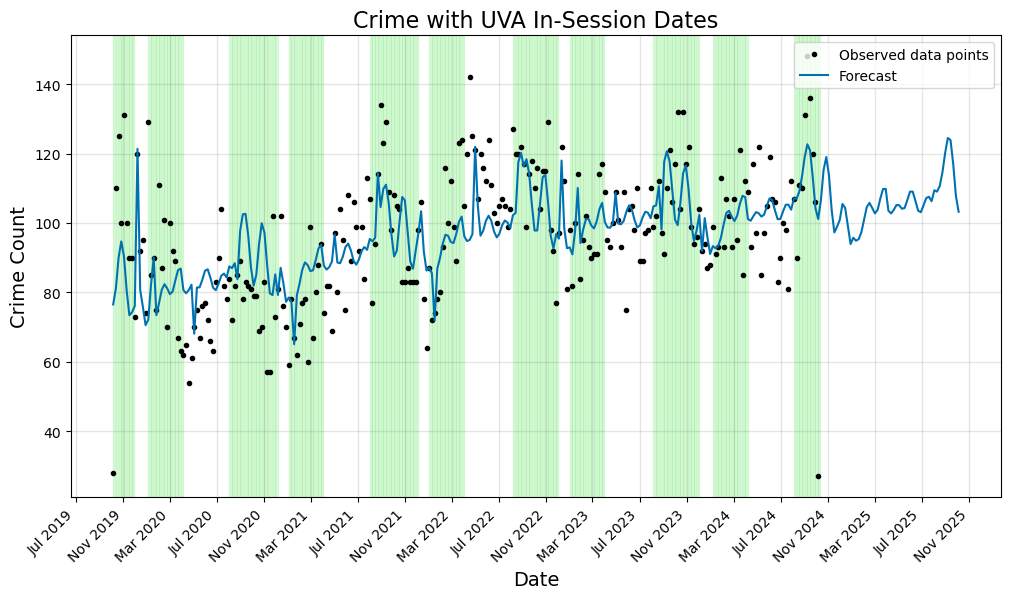

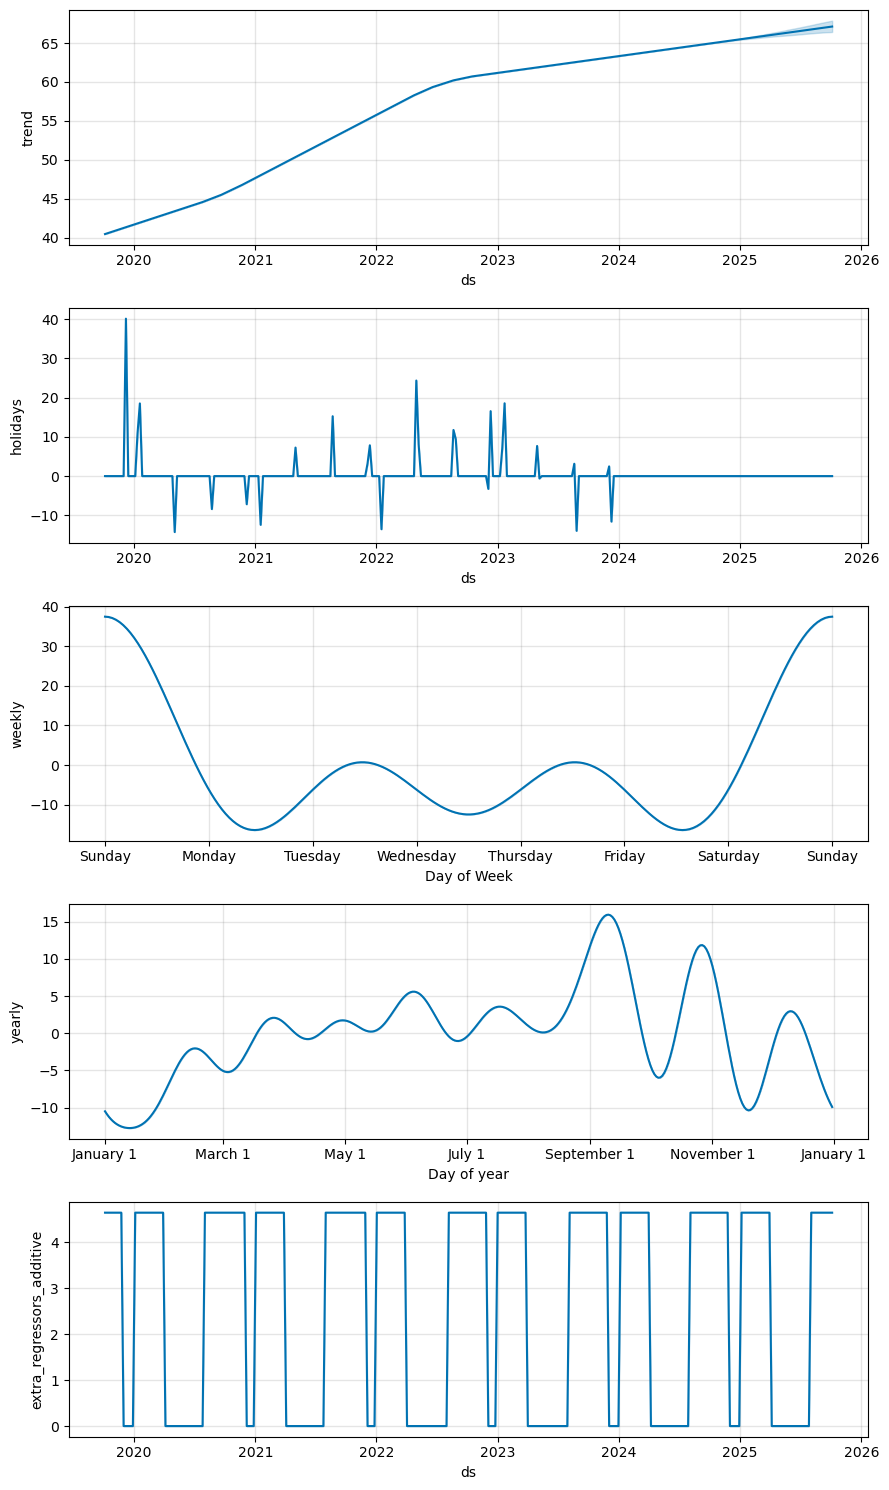

In [26]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Plot forecast with holiday and InSession shading
fig, ax = plt.subplots(figsize=(12, 6))
model3.plot(forecast3, ax=ax, uncertainty=False)

# Shade holidays
# for _, row in uva_holidays.iterrows():
#     holiday_start = row["ds"] + pd.Timedelta(days=row["lower_window"])
#     holiday_end = row["ds"] + pd.Timedelta(days=row["upper_window"])
#     ax.axvspan(holiday_start, holiday_end, color="green", alpha=0.3)

# Shade InSession periods with more opacity
for _, row in df_weekly.iterrows():
    if row["InSession"] == 1:
        in_session_start = row["ds"]
        in_session_end = in_session_start + pd.Timedelta(days=6)  # Weekly period
        ax.axvspan(in_session_start, in_session_end, color="lightgreen", alpha=0.3)  # More opaque shading

# Customize title and axes 
ax.set_title("Crime with UVA In-Session Dates", fontsize=16)
ax.grid(True, which='both', color='gray', alpha=0.2)
ax.set_xlabel("Date", fontsize=14)
ax.set_ylabel("Crime Count", fontsize=14)

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')


plt.show()

# Plot seasonality components
fig2 = model3.plot_components(forecast3)
plt.show()


In [27]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error

# Validation
# Split dataset for validation
train_size = int(len(df_weekly) * 0.8)
train, test = df_weekly.iloc[:train_size], df_weekly.iloc[train_size:]

# Initialize new Prophet model for validation
model_val3 = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    holidays=uva_holidays  # Include holidays in validation model
)

# Fit model on training set
model_val3.fit(train)

# Predict on test set
test_forecast3 = model_val3.predict(test)

# Evaluate model
mae3 = mean_absolute_error(test["y"], test_forecast3["yhat"])
rmse3 = root_mean_squared_error(test["y"], test_forecast3["yhat"])
mape3 = mean_absolute_percentage_error(test["y"], test_forecast3["yhat"])

print(f"Mean Absolute Error (MAE): {mae3}")
print(f"Root Mean Squared Error (RMSE): {rmse3}")
print(f"Mean Absolute Percentage Error (MAPE): {mape3}")


10:41:53 - cmdstanpy - INFO - Chain [1] start processing
10:41:53 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error (MAE): 11.820485635491181
Root Mean Squared Error (RMSE): 17.310910064515372
Mean Absolute Percentage Error (MAPE): 0.16044533874170602


## Additional Model

In [28]:
import os
import pandas as pd
from prophet import Prophet
from pathlib import Path

# File paths
script_dir = Path.cwd()
data_dir = script_dir.parent / "data"
file_path = data_dir / "cleaned_data2.csv"

# Read the data
# df = pd.read_csv(x)
df = pd.read_csv(file_path)

# Convert DateReported to tz-aware
df["DateReported"] = pd.to_datetime(df["DateReported"], errors="coerce", utc=True)

# Resample weekly, counting occurrences
df_weekly = df.resample("W", on="DateReported").size().reset_index(name="y")
df_weekly = df_weekly.rename(columns={"DateReported": "ds"})

df_weekly["ds"] = df_weekly["ds"].dt.tz_localize(None)
df_weekly = df_weekly.sort_values("ds")

# Add InSession indicator
df_weekly["InSession"] = df_weekly["ds"].apply(lambda x: 1 if x.month in [1, 2, 3, 8, 9, 10, 11] else 0)

# Define UVA holidays
uva_holidays = []
start_year, end_year = 2019, 2025  # Extend holiday range to cover 2019 to 2025
for year in range(start_year, end_year + 1):
    uva_holidays.extend([
        {"holiday": "Fall semester start", "ds": f"{year}-08-24"},
        {"holiday": "Fall semester end", "ds": f"{year}-12-06"},
        {"holiday": "Winter break start", "ds": f"{year}-12-07"},
        {"holiday": "Winter break end", "ds": f"{year}-01-17"},
        {"holiday": "Spring semester start", "ds": f"{year}-01-18"},
        {"holiday": "Spring semester end", "ds": f"{year}-05-02"},
        {"holiday": "Summer break start", "ds": f"{year}-05-03"},
        {"holiday": "Summer break end", "ds": f"{year}-08-23"},
    ])

# Convert holidays to DataFrame with window effects
uva_holidays = pd.DataFrame(uva_holidays)
uva_holidays["ds"] = pd.to_datetime(uva_holidays["ds"])
uva_holidays["lower_window"] = uva_holidays["holiday"].apply(lambda x: -5 if "break" in x else -2)
uva_holidays["upper_window"] = uva_holidays["holiday"].apply(lambda x: 5 if "break" in x else 2)

# Initialize and fit the Prophet model
model3 = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    holidays=uva_holidays
)

# Add InSession as a regressor
model3.add_regressor("InSession")

# Fit model
model3.fit(df_weekly)

# Create future dataframe
future = model3.make_future_dataframe(periods=365, freq="W")  # Extend future range
future["InSession"] = future["ds"].apply(lambda x: 1 if x.month in [1, 2, 3, 8, 9, 10, 11] else 0)

# Predict
forecast3 = model3.predict(future)


/var/folders/r9/vr40l1ss0v71ty4xxtt_10j00000gn/T/ipykernel_49407/2118230638.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["DateReported"] = pd.to_datetime(df["DateReported"], errors="coerce", utc=True)
10:41:54 - cmdstanpy - INFO - Chain [1] start processing
10:41:54 - cmdstanpy - INFO - Chain [1] done processing


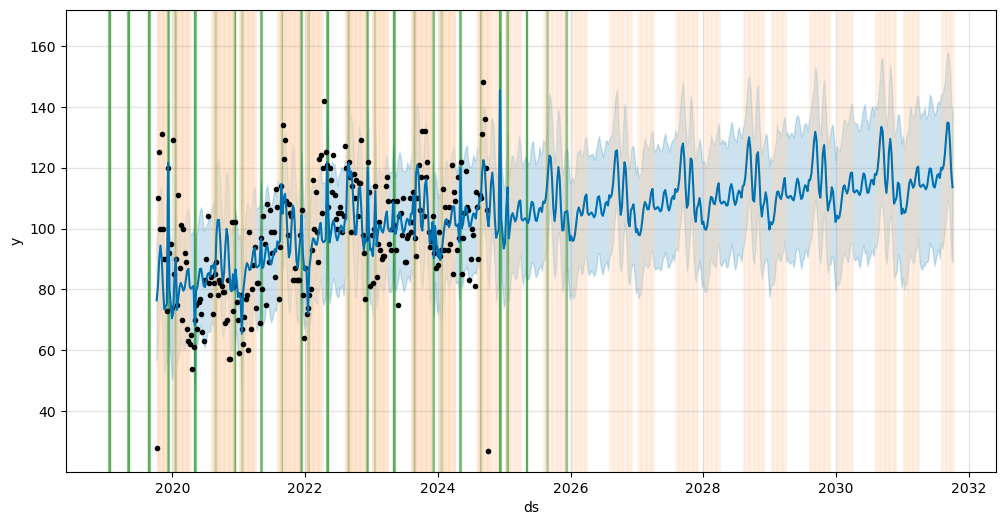

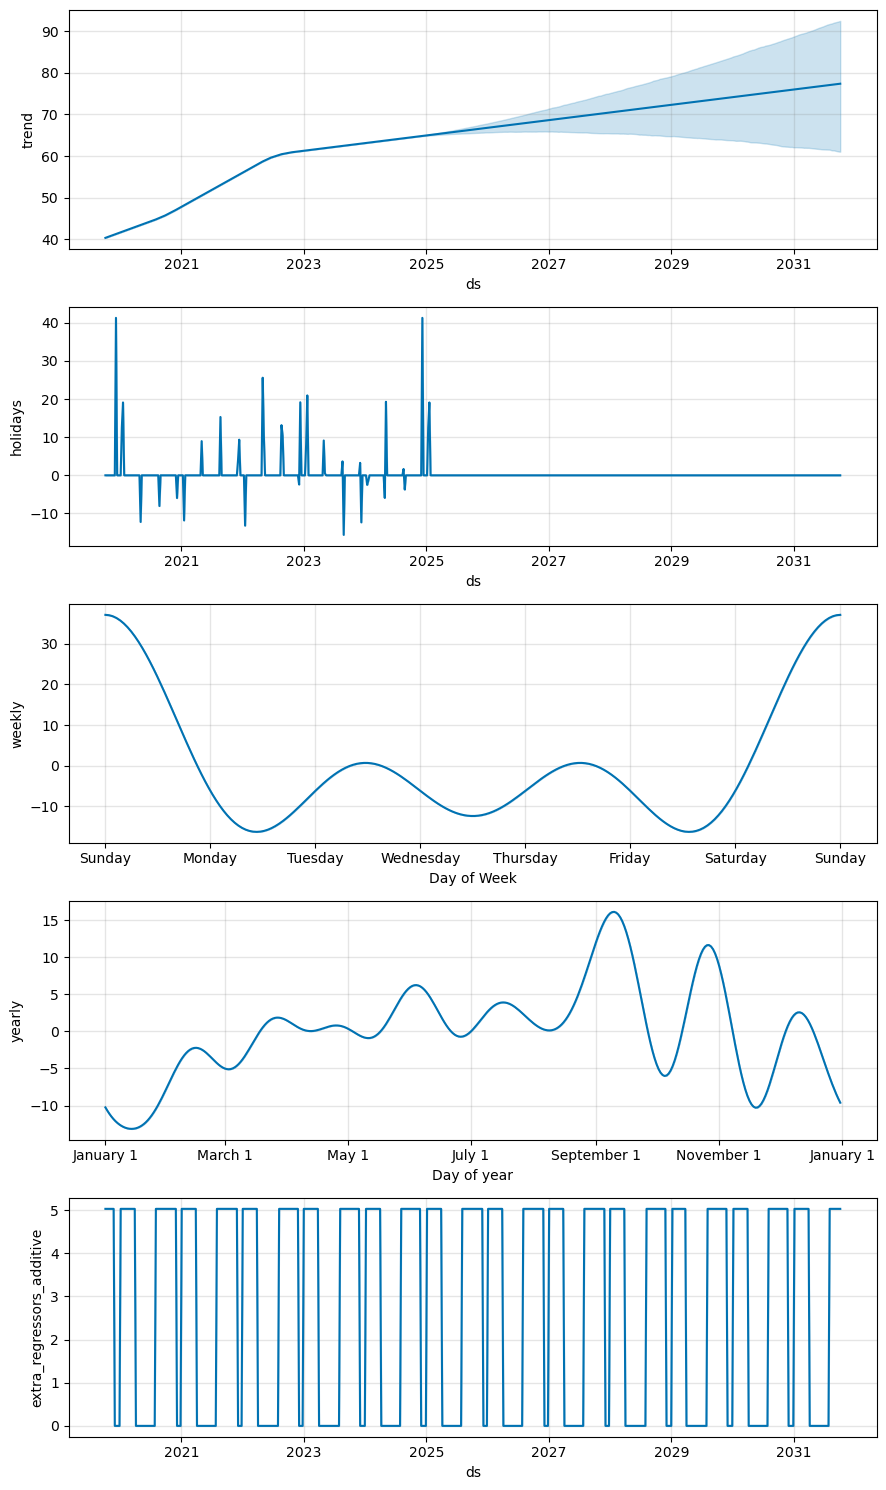

In [29]:
import matplotlib.pyplot as plt

# Plot forecast with holiday and InSession shading
fig, ax = plt.subplots(figsize=(12, 6))
model3.plot(forecast3, ax=ax)

# Shade holidays
for _, row in uva_holidays.iterrows():
    holiday_start = row["ds"] + pd.Timedelta(days=row["lower_window"])
    holiday_end = row["ds"] + pd.Timedelta(days=row["upper_window"])
    ax.axvspan(holiday_start, holiday_end, color="green", alpha=0.3)

# Shade InSession periods
for _, row in pd.concat([df_weekly, future]).iterrows():
    if row["InSession"] == 1:
        in_session_start = row["ds"]
        in_session_end = in_session_start + pd.Timedelta(days=6)  # Weekly period
        ax.axvspan(in_session_start, in_session_end, color="peachpuff", alpha=0.2)

plt.show()

# Plot seasonality components
fig2 = model3.plot_components(forecast3)
plt.show()


# Comparing the Models

In [34]:
comp_df = pd.DataFrame({
    "Model": ["InSession", "Holidays", "InSession + Holidays"],
    "MAE": [mae1, mae2, mae3],
    "RMSE": [rmse1, rmse2, rmse3],
    "MAPE": [mape1, mape2, mape3]
})

comp_df = comp_df.round(4)
comp_df


,Model,MAE,RMSE,MAPE
0,InSession,12.2217,17.5718,0.1648
1,Holidays,11.8205,17.3109,0.1604
2,InSession + Holidays,11.8205,17.3109,0.1604
